In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gauss_1d(x,center,sigma):    
    y = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(1/2)*((x-center)/sigma)**2)    
    return y

def von_mises_deg(xx,mu,k,a=1,b=0):
  # make a von mises function over the range in xx
  # assume the input is 0-180 or 0-360 deg space.
    axis_size_deg = np.max(xx)+1
    if k<10**(-15):
        print('WARNING: k is too small, might get precision errors')
    
    xx_rad2pi = np.float128(xx/axis_size_deg*2*np.pi)
    mu_rad2pi = mu/axis_size_deg*2*np.pi
    yy = np.exp(k*(np.cos(xx_rad2pi-mu_rad2pi)-1))

    # first make the y values span from 0-1
    yy = yy-min(yy)
    yy = yy/max(yy)

    # then apply the entered amplitude and baseline.
    yy = a*yy+b

    return yy

In [51]:
# prior_centers = [45,135]
prior_centers = [45,135]
prior_ks = [8,8]
# prior_ks = [10e-8, 10e-8]
stim_axis = np.arange(0,180)
base = 0.0
g = np.array([von_mises_deg(stim_axis, prior_centers[ii], prior_ks[ii]) \
              for ii in range(len(prior_centers))])
prior_dist = np.sum(g, axis=0)+base
# prior_dist /= np.sum(prior_dist)

In [4]:
# tuning_dist_centers = [45,135]
tuning_dist_centers = [0,90]
tuning_dist_ks = [10,10]
stim_axis = np.arange(0,180)
base = 0.10
g = np.array([von_mises_deg(stim_axis, tuning_dist_centers[ii], tuning_dist_ks[ii]) \
              for ii in range(len(tuning_dist_centers))])
tuning_dist = np.sum(g, axis=0) + base
tuning_dist /= np.sum(tuning_dist)

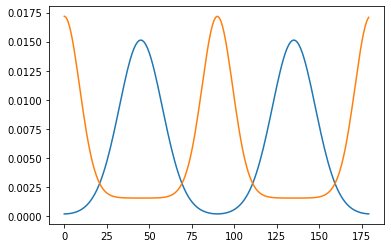

In [22]:
plt.figure();
plt.plot(stim_axis, prior_dist)
plt.plot(stim_axis, tuning_dist)

In [23]:
n_voxels = 1000
voxel_prefs = np.random.choice(stim_axis,size=(n_voxels,), replace=True, \
                               p=tuning_dist.astype('float64'))
voxel_ks = np.ones((n_voxels,))*10

voxel_tc = np.array([von_mises_deg(stim_axis, voxel_prefs[vv], voxel_ks[vv]) \
                     for vv in range(n_voxels)])
voxel_tc /= np.tile(np.sum(voxel_tc, axis=1, keepdims=True), [1,voxel_tc.shape[1]])

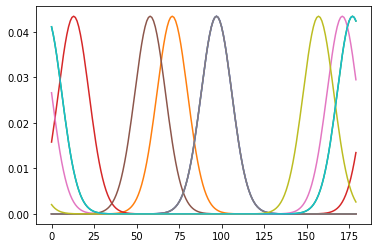

In [24]:
plt.figure();
for vv in range(10):
    plt.plot(stim_axis, voxel_tc[vv,:])

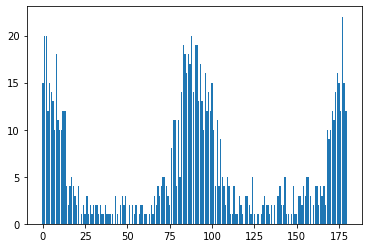

In [25]:
plt.figure();
n_each = np.array([np.sum(voxel_prefs==ii) for ii in stim_axis])
plt.bar(stim_axis, n_each);

In [26]:
n_trials = 800;
trial_stims = np.random.choice(stim_axis,size=(n_trials,), replace=True, \
                               p=prior_dist.astype('float64'))

design_matrix = np.zeros((n_trials, len(stim_axis)))
for tt in range(n_trials):
    ind = np.where(trial_stims[tt]==stim_axis)[0][0]
    design_matrix[tt,ind] = 1;
assert(all(np.sum(design_matrix, axis=1)==1))

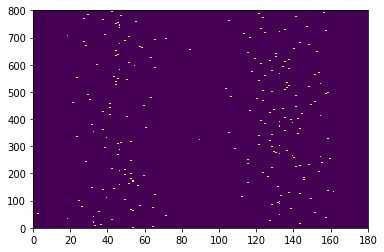

In [27]:
plt.figure();
plt.pcolormesh(design_matrix)

In [38]:
n_trials = 800;
mean_each_feature = prior_dist
var_each_feature = prior_dist*2
design_matrix = np.zeros((n_trials, len(stim_axis)))
for si, st in enumerate(stim_axis):
    design_matrix[:,si] = np.random.normal(mean_each_feature[si], var_each_feature[si], n_trials)
    
# design_matrix /= np.tile(np.sum(design_matrix, axis=1, keepdims=True), [1, design_matrix.shape[1]])


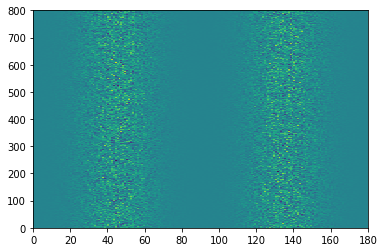

In [39]:
plt.figure();
plt.pcolormesh(design_matrix)

In [261]:
design_matrix.shape

(800, 180)

In [40]:
noiseless_resp = voxel_tc @ design_matrix.T
noise_sigma = 0.0
noisy_resp = noiseless_resp + np.random.normal(0,noise_sigma, np.shape(noiseless_resp))

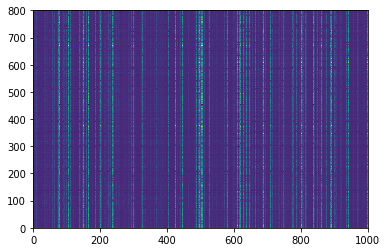

In [41]:
plt.figure();
plt.pcolormesh(noisy_resp.T)

In [42]:
# noisy_resp = design_matrix @ wts
design_matrix = np.concatenate([design_matrix, np.ones((n_trials,1))], axis=1)
wts = noisy_resp @ np.linalg.pinv(design_matrix).T

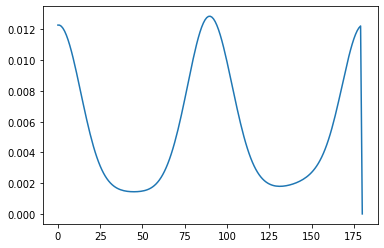

In [43]:
plt.figure();
plt.plot(np.mean(wts, axis=0))

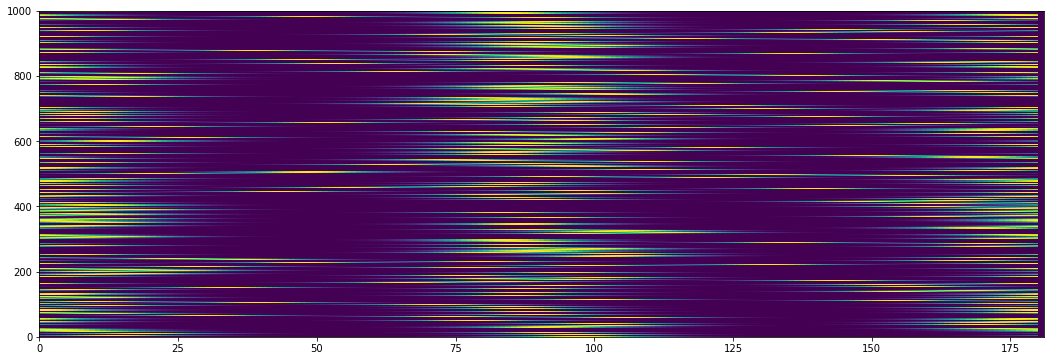

In [44]:
plt.figure(figsize=(18,6));
plt.pcolormesh(wts)

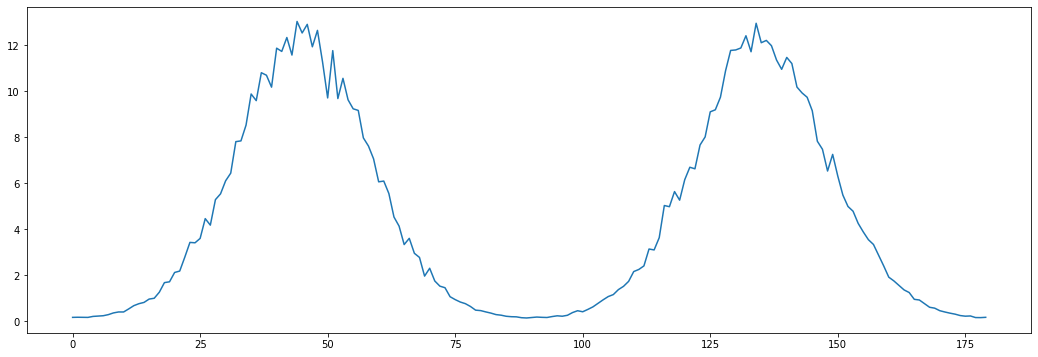

In [49]:
plt.figure(figsize=(18,6));
plt.plot(np.sum(design_matrix[:,0:180], axis=0))
# plt.pcolormesh(design_matrix[:,0:180]);
# plt.colorbar()

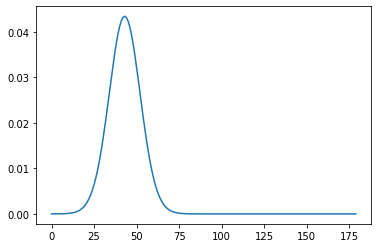

In [247]:
plt.figure();
vv = 0;
plt.plot(voxel_tc[vv,:])

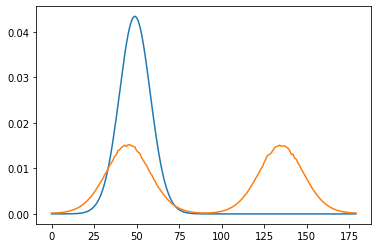

In [223]:
plt.figure();
vv = 0
tt = 431
plt.plot(voxel_tc[vv,:])
plt.plot(design_matrix[tt,:])

In [201]:
voxel_tc[vv,:] @ design_matrix[tt,:]

0.28565247678421880844

In [224]:
np.max(noiseless_resp)

0.012385873609717504817

In [195]:
np.argmax(np.max(noiseless_resp, axis=0))

431

In [196]:
np.argmax(noiseless_resp[:,431])

0

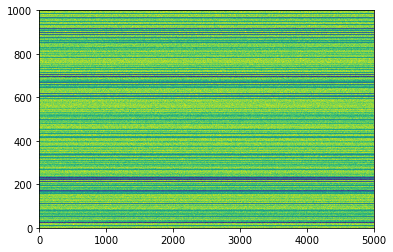

In [191]:
plt.figure();
plt.pcolormesh(noisy_resp)

array([[1.        , 0.20294043],
       [0.20294043, 1.        ]], dtype=float128)

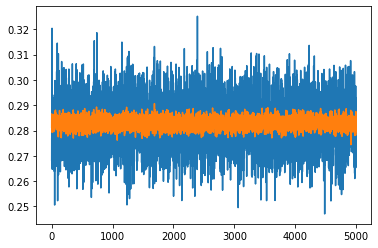

In [192]:
pred_resp = design_matrix @ wts.T

vv=0
plt.figure();
plt.plot(noisy_resp[vv,:])
plt.plot(pred_resp[:,vv])

np.corrcoef(noisy_resp[vv,:], pred_resp[:,vv])